Dimensiones: (750000, 9)

Tipos de variables:
 id              int64
Sex            object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object

Valores faltantes:
 id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64


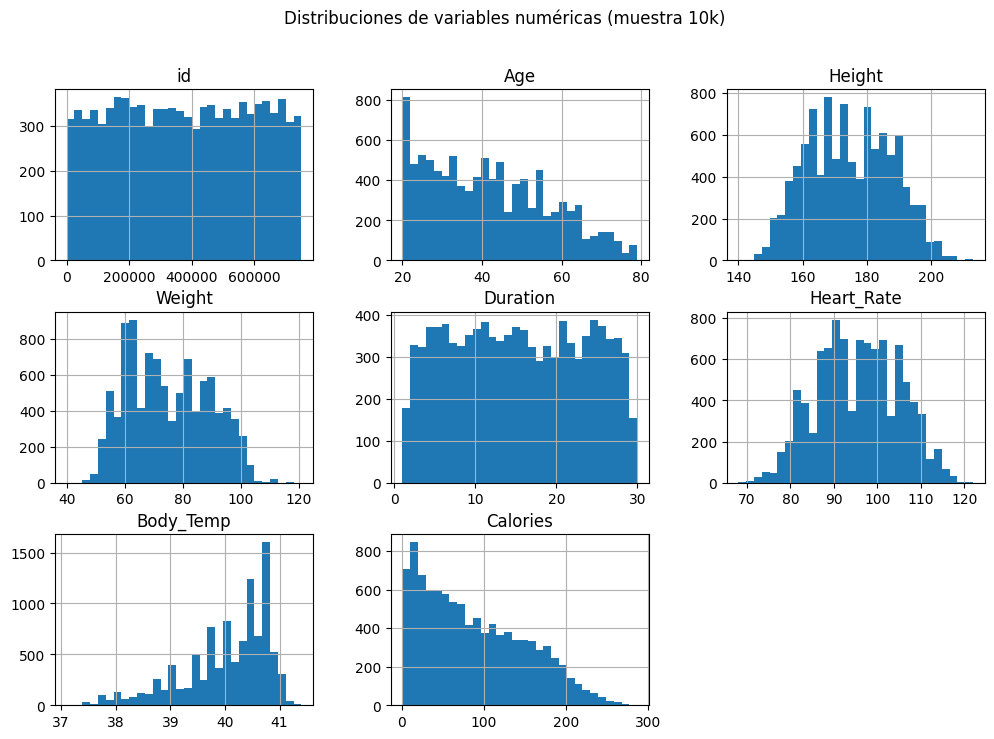

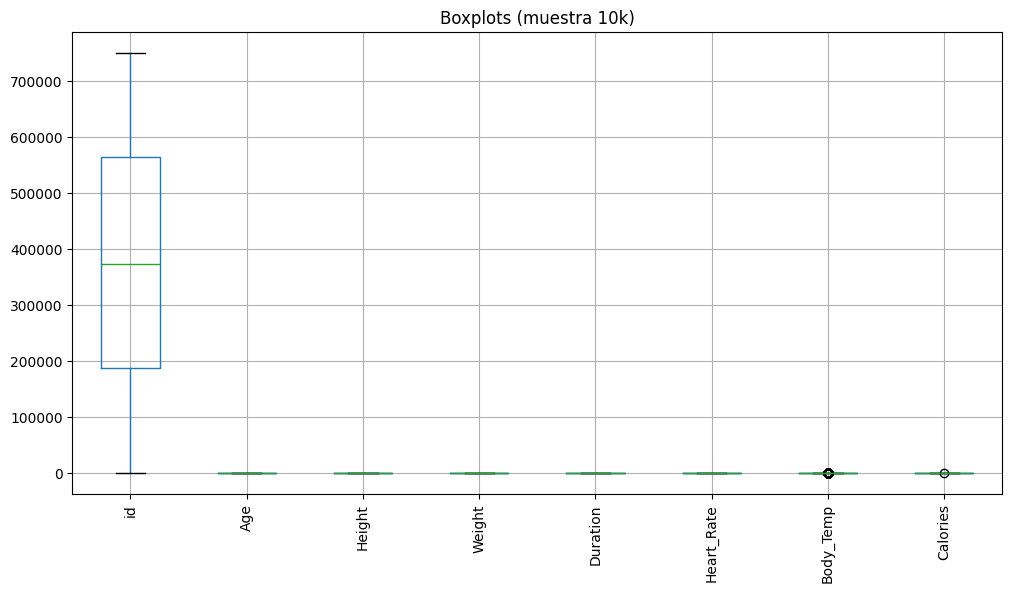

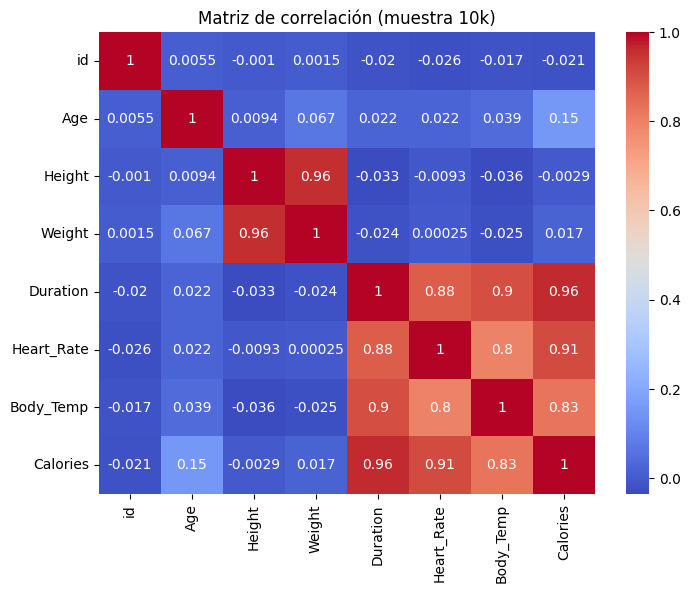


Correlación con Calories:
 Calories      1.000000
Duration      0.959858
Heart_Rate    0.908612
Body_Temp     0.827807
Age           0.153499
Weight        0.016635
Height       -0.002918
id           -0.020772
Name: Calories, dtype: float64

Entrenando LinearRegression...

Entrenando Ridge...

Entrenando HistGradientBoosting...

Entrenando RandomForest...

Métricas de los modelos:
                            MAE       RMSE        R2
LinearRegression      8.143595  11.165897  0.968323
Ridge                 8.143580  11.165899  0.968323
HistGradientBoosting  2.467817   3.955315  0.996025
RandomForest          2.455091   4.098968  0.995731


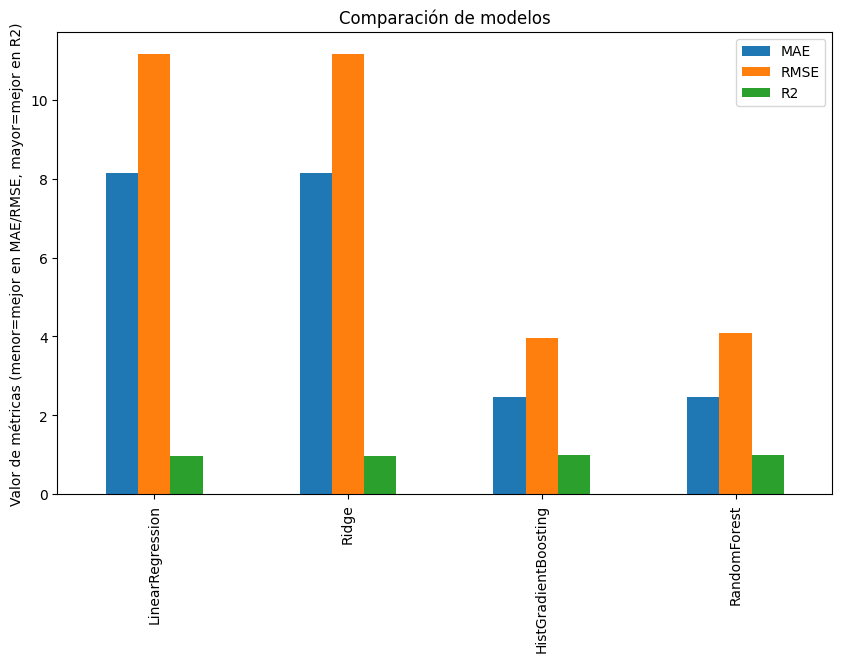


Mejor modelo: HistGradientBoosting


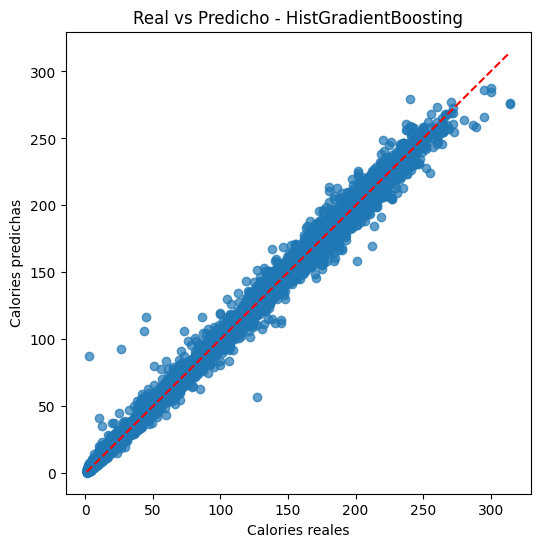

In [ ]:
# ======================================
# Taller de Regresión - Predicción de Calorías
# ======================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==============================
# 1. Carga de datos
# ==============================
df = pd.read_csv("calories.csv")

print("Dimensiones:", df.shape)
print("\nTipos de variables:\n", df.dtypes)
print("\nValores faltantes:\n", df.isnull().sum())

# ==============================
# 2. Exploración con muestra
# ==============================
df_sample = df.sample(10000, random_state=42)  # 10k filas para que sea mas rápido

# Distribuciones
df_sample.hist(bins=30, figsize=(12, 8))
plt.suptitle("Distribuciones de variables numéricas (muestra 10k)")
plt.show()

# Boxplots
plt.figure(figsize=(12, 6))
df_sample.boxplot(rot=90)
plt.title("Boxplots (muestra 10k)")
plt.show()

# Correlación con el target
corr = df_sample.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación (muestra 10k)")
plt.show()

print("\nCorrelación con Calories:\n", corr["Calories"].sort_values(ascending=False))

# ==============================
# 3. Preprocesamiento
# ==============================
# Codificación de variable categórica (Sex)
df["Sex"] = df["Sex"].map({"female": 0, "male": 1})

# Separar variables predictoras y target
X = df.drop(["Calories", "id"], axis=1)  # quitamos id porque no aporta
y = df["Calories"]

# Para entrenar más rápido usamos 100k filas
X_train_full, _, y_train_full, _ = train_test_split(X, y, train_size=100000, random_state=42)

# Dividir train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# Columnas numéricas y categóricas
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

# ==============================
# 4. Modelos
# ==============================
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)  # reducido
}

results = {}

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

# Resultados
results_df = pd.DataFrame(results).T
print("\nMétricas de los modelos:\n", results_df)

# ==============================
# 5. Visualización de desempeño
# ==============================
results_df.plot(kind="bar", figsize=(10, 6))
plt.title("Comparación de modelos")
plt.ylabel("Valor de métricas (menor=mejor en MAE/RMSE, mayor=mejor en R2)")
plt.show()

# Mejor modelo
best_model_name = results_df["R2"].idxmax()
print("\nMejor modelo:", best_model_name)

# Ajuste final del mejor modelo
best_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                            ("model", models[best_model_name])])
best_pipe.fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)

# Real vs Predicho
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.title(f"Real vs Predicho - {best_model_name}")
plt.xlabel("Calories reales")
plt.ylabel("Calories predichas")
plt.show()
